In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, random_split, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import cv2 

from PIL import Image
import os

In [2]:
import os
from glob import glob

hand_datasets_root = "hands"         # your main folder
negative_root = "Negatives"          # folder with no-hand images

hand_image_paths = []
test_image_paths = []
nohand_image_paths = []
nohand_test_image_paths = []

# Collect HAND images from all datasets
for dataset in os.listdir(hand_datasets_root):
    ds_path = os.path.join(hand_datasets_root, dataset)
    if not os.path.isdir(ds_path):
        continue
    
    # Add train images
    train_images = glob(os.path.join(ds_path, "train/images", "*.jpg")) + \
                   glob(os.path.join(ds_path, "train/images", "*.png"))
    
    # Add test images
    test_images = glob(os.path.join(ds_path, "test/images", "*.jpg")) + \
                  glob(os.path.join(ds_path, "test/images", "*.png"))
    
    hand_image_paths.extend(train_images)
    test_image_paths.extend(test_images)



for dataset in os.listdir(negative_root):
    nohand_path = os.path.join(negative_root, dataset)
    if not os.path.isdir(nohand_path):
        continue
    
    # Add train images
    nohand_image_train = glob(os.path.join(nohand_path, "images", "*.jpg")) + \
                   glob(os.path.join(nohand_path, "images/NoObject", "*.png")) 
    
    # # Add test images
    # nohand_image_test = glob(os.path.join(ds_path, "test/images", "*.jpg")) + \
    #               glob(os.path.join(ds_path, "test/images", "*.png"))

    nohand_image_paths.extend(nohand_image_train)
    # nohand_test_image_paths.extend(test_images)

import random

DEV_RATIO = 0.1  # 15% dev split

random.shuffle(nohand_image_paths)

nohand_dev_count = int(len(nohand_image_paths) * DEV_RATIO)

# DEV SET
nohand_dev = nohand_image_paths[:nohand_dev_count]

# TRAIN SET
nohand_train = nohand_image_paths[nohand_dev_count:]

    
# Collect NO-HAND images
# nohand_image = glob(os.path.join(negative_root, "*.jpg")) + \
                    #  glob(os.path.join(negative_root, "*.png"))

print("Hand images found:", len(hand_image_paths))
print("Test images found:", len(test_image_paths))
print("No-hand images found:", len(nohand_train))
print("No hand test:", len(nohand_dev))
# print(16935 + 1842)


Hand images found: 31935
Test images found: 1332
No-hand images found: 13704
No hand test: 1522


In [3]:
from torch.utils.data import Dataset
from PIL import Image

class HandDataset(Dataset):
    def __init__(self, hand_paths, nohand_paths, transform=None):
        self.hand_paths = hand_paths
        self.nohand_paths = nohand_paths
        self.transform = transform
        
        # Create a combined list with labels
        self.images = hand_paths + nohand_paths
        self.labels = [1] * len(hand_paths) + [0] * len(nohand_paths)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [4]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

train_transform = T.Compose([
    # T.ToPILImage(),
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


In [5]:
dataset = HandDataset(hand_image_paths, nohand_train, transform= train_transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:
dev_dataset = HandDataset(test_image_paths, nohand_dev, transform= test_transform)
dev_loader = DataLoader(dev_dataset, batch_size = 32, shuffle = False)

In [7]:
class HandOrNotCNN(nn.Module):
    def __init__(self):
        super(HandOrNotCNN, self).__init__()
        def block(inp, out):
            return nn.Sequential(
                nn.Conv2d(inp, out, kernel_size=3, padding=1),
                nn.BatchNorm2d(out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)   # 224 -> 112
            )
        
        self.conv1 = block(3, 32)
        self.conv2 = block(32, 64)
        self.conv3 = block(64, 128)
        self.conv4 = block(128, 128)
        self.maxp = nn.MaxPool2d(2)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128*7*7, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32,2)
            )


    def forward(self, x):
        x = self.conv1(x)   # [B, 32, 112, 112]
        x = self.conv2(x)   # [B, 64, 56, 56]
        x = self.conv3(x)   # [B, 128, 28, 28]
        x = self.conv4(x)
        x = self.maxp(x)
        # print(x.shape)
        # x = self.gap(x)     # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 128]
        x = self.fc(x)      # [B, 1] (logits)
        return x


In [8]:
model = HandOrNotCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = t.device("mps" if t.backends.mps.is_available() else "cpu")
model = model.to(device)
device


device(type='mps')

In [9]:
epochs = 5
cost_hist = []
cost_hist_dev = []

for i in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        _, predicted = t.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_loss / total_train 
    train_acc = (correct_train / total_train) * 100
    cost_hist.append(avg_train_loss)
    

    model.eval()
    dev_loss = 0
    correct_dev, total_dev = 0, 0
    with t.no_grad():
        for images_d, labels_d in dev_loader:
            images_d, labels_d = images_d.to(device), labels_d.to(device)

            dev_output = model(images_d)
            loss_d = criterion(dev_output, labels_d)

            dev_loss += loss_d.item() * images_d.size(0)

            _, predicted_d = t.max(dev_output, 1)
            total_dev += labels_d.size(0)
            correct_dev += (predicted_d == labels_d).sum().item()

        avg_dev_loss = dev_loss / total_dev  
        dev_acc = (correct_dev / total_dev) * 100
        

    print(f"Epochs: {i+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Dev Loss: {avg_dev_loss:.4f}, Dev Acc: {dev_acc:.2f}%")



Epochs: 1, Train Loss: 0.4618, Train Acc: 73.37%, Dev Loss: 0.3657, Dev Acc: 86.79%
Epochs: 2, Train Loss: 0.3840, Train Acc: 79.82%, Dev Loss: 0.3099, Dev Acc: 94.46%
Epochs: 3, Train Loss: 0.3486, Train Acc: 82.76%, Dev Loss: 0.2582, Dev Acc: 94.39%
Epochs: 4, Train Loss: 0.3191, Train Acc: 84.97%, Dev Loss: 0.2394, Dev Acc: 95.06%
Epochs: 5, Train Loss: 0.2964, Train Acc: 86.60%, Dev Loss: 0.2201, Dev Acc: 95.55%


In [10]:
from sklearn.metrics import precision_score, recall_score

all_preds, all_labels = [], []

with t.no_grad():
    for images_d, labels_d in dev_loader:
        images_d, labels_d = images_d.to(device), labels_d.to(device)
        outputs = model(images_d)
        preds = t.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_d.cpu().numpy())

precision = precision_score(all_labels, all_preds, pos_label=1)
recall = recall_score(all_labels, all_preds, pos_label=1)

print("Precision:", precision, "Recall:", recall)


Precision: 0.9362780593772628 Recall: 0.9707207207207207


<Axes: >

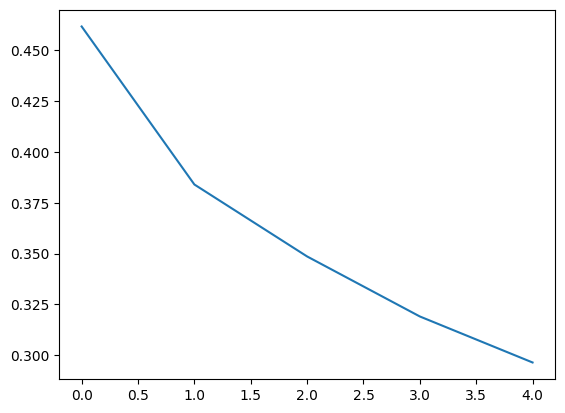

In [14]:
sns.lineplot(x = range(len(cost_hist)), y = cost_hist)

In [11]:
t.save(model.state_dict(), "hand_model.pth")

In [15]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np

# ---------- CONFIG: CHANGE THESE ----------
MODEL_PATH = "better_hand_class.pth"  # path to your saved model
CLASS_NAMES = ["no_hand", "hand"]  # change to your own classes
INPUT_SIZE = 224  # resize camera frames to this
USE_GPU = torch.mps.is_available()
# -----------------------------------------

class HandOrNotCNN(nn.Module):
    def __init__(self):
        super(HandOrNotCNN, self).__init__()
        def block(inp, out):
            return nn.Sequential(
                nn.Conv2d(inp, out, kernel_size=3, padding=1),
                nn.BatchNorm2d(out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)   # 224 -> 112
            )
        
        self.conv1 = block(3, 32)
        self.conv2 = block(32, 64)
        self.conv3 = block(64, 128)
        self.conv4 = block(128, 128)
        self.maxp = nn.MaxPool2d(2)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(128*7*7, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32,2)
            )


    def forward(self, x):
        x = self.conv1(x)   # [B, 32, 112, 112]
        x = self.conv2(x)   # [B, 64, 56, 56]
        x = self.conv3(x)   # [B, 128, 28, 28]
        x = self.conv4(x)
        x = self.maxp(x)
        # print(x.shape)
        # x = self.gap(x)     # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 128]
        x = self.fc(x)      # [B, 1] (logits)
        return x


def load_model():
    """
    Load your model here.
    Replace this with the exact architecture you used for training.
    """
    # Example: simple resnet18 classifier
    # from torchvision.models import resnet18

    model = HandOrNotCNN()
    # Change final layer to match num classes
    # model.fc = n n.Linear(model.fc.in_features, len(CLASS_NAMES))

    # Load weights
    state = torch.load(MODEL_PATH, map_location="cpu")
    model.load_state_dict(state)

    model.eval()
    if USE_GPU:
        model.to("mps")
    return model


# Preprocessing transform for each frame
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet mean/std
                std=[0.229, 0.224, 0.225])
])


@torch.no_grad()
def predict_frame(model, frame_bgr):
    """
    Takes a BGR frame (from OpenCV), returns (predicted_label, confidence)
    """
    # Convert BGR (OpenCV) → RGB (PyTorch convention)
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # Apply transforms
    img = transform(frame_rgb)  # shape: [C, H, W]
    img = img.unsqueeze(0)      # shape: [1, C, H, W]

    if USE_GPU:
        img = img.to("mps")

    # Forward pass
    logits = model(img)  # [1, num_classes]
    probs = torch.softmax(logits, dim=1)[0]  # [num_classes]

    conf, pred_idx = torch.max(probs, dim=0)
    label = CLASS_NAMES[pred_idx.item()]
    return label, conf.item()


def main():
    print("Loading model...")
    model = load_model()
    print("Model loaded. Opening camera...")

    cap = cv2.VideoCapture(0)  # 0 = default camera
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Predict on current frame
        label, conf = predict_frame(model, frame)

        # Draw prediction on the frame
        text = f"{label} ({conf*100:.1f}%)"
        cv2.putText(
            frame, text,
            (10, 30),                  # position
            cv2.FONT_HERSHEY_SIMPLEX,  # font
            1.0,                       # font scale
            (0, 255, 0),               # color (B, G, R)
            2,                         # thickness
            cv2.LINE_AA
        )

        # Show the frame
        cv2.imshow("Live Prediction", frame)

        # If user presses 'q' → quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()


Loading model...
Model loaded. Opening camera...
Press 'q' to quit.


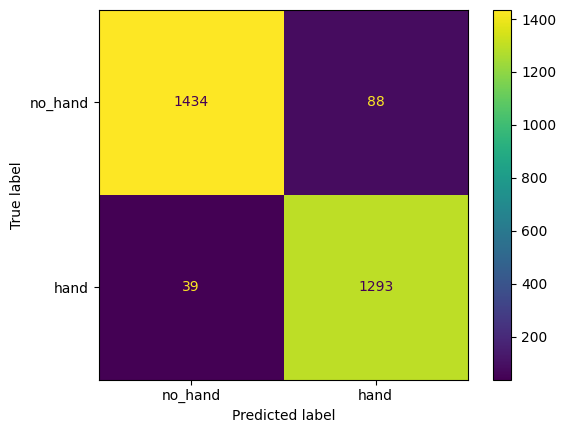

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot()
plt.savefig('confusion_matrix.png')